# Setup

This requires fastai V1

## Dependencies

In [94]:
# General
import os
from os import path
import shutil
import glob

# Data processing
import pandas as pd
import numpy as np

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# ScikitLearn
from sklearn.model_selection import train_test_split

# Plots
import matplotlib.pyplot as plt

random_state = 42


## Prepare Dataset

In [3]:
# Get paths
raw_data_path = path.join(os.getcwd(), "rawdata")

In [29]:
def get_image_df(data_path, labels_filter=["Covid-19", "No_findings"]):
    labels = os.listdir(data_path)
    columns = ["image_path", "label"]
    
    images = []
    for label in labels:
        if label not in labels_filter:
            continue
        label_image_paths = os.listdir(path.join(data_path, label))
        label_images = list(map(lambda im_path: [f"{label}/{im_path}", label], label_image_paths))
        images.extend(label_images)
        
    return pd.DataFrame(images, columns=columns)
        
df = get_image_df(raw_data_path)
df.sample(5).head()

,image_path,label
77,Covid-19/1.CXRCTThoraximagesofCOVID-19fromSing...,Covid-19
538,No_findings/00003828_000.png,No_findings
150,No_findings/00002474_006.png,No_findings
623,No_findings/00001504_001.png,No_findings
490,No_findings/00003393_030.png,No_findings


In [45]:
# Stratify split into train and test
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=df['label'], random_state=random_state)

In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Load dataset

In [34]:
image_size = (256, 256)
batch_size = 32

In [18]:




np.random.seed(41)
data = ImageDataBunch.from_folder(data_path, train="train", valid ="test",
        ds_tfms=get_transforms(), size=image_size, bs=batch_size, num_workers=4).normalize()

In [169]:
#Train datagen here is a preprocessor
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                   rescale=1./255,
                                   horizontal_flip = True,
                                   rotation_range=15,
    
    
                                   # featurewise_center = True, # Not Center image, center values, across all images
                                   # featurewise_std_normalization = True, # Normalise across all images
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   # zca_whitening = True,
                                   channel_shift_range = 20,

                                   # vertical_flip = True,
                                   # validation_split = 0.2,
                                   fill_mode='constant')

train_batches = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory=raw_data_path,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  batc_size=batch_size,
                                                  seed=random_state,
                                                  class_mode='categorical',
                                                  target_size=image_size)


test_batches = train_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory=raw_data_path,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  batc_size=batch_size,
                                                  seed=random_state,
                                                  class_mode='categorical',
                                                  target_size=image_size)

Found 500 validated image filenames belonging to 2 classes.
Found 125 validated image filenames belonging to 2 classes.


# EDA

In [63]:
train_batches.class_indices, len(train_df), len(test_df)

({'Covid-19': 0, 'No_findings': 1}, 500, 125)

In [64]:
print("Number of examples in training:", len(train_df))
print("Number of examples in validation:", len(test_df))

Number of examples in training: 500
Number of examples in validation: 125


In [66]:
xb, yb = train_batches.next()
xb.shape,yb.shape

((32, 256, 256, 3), (32,))

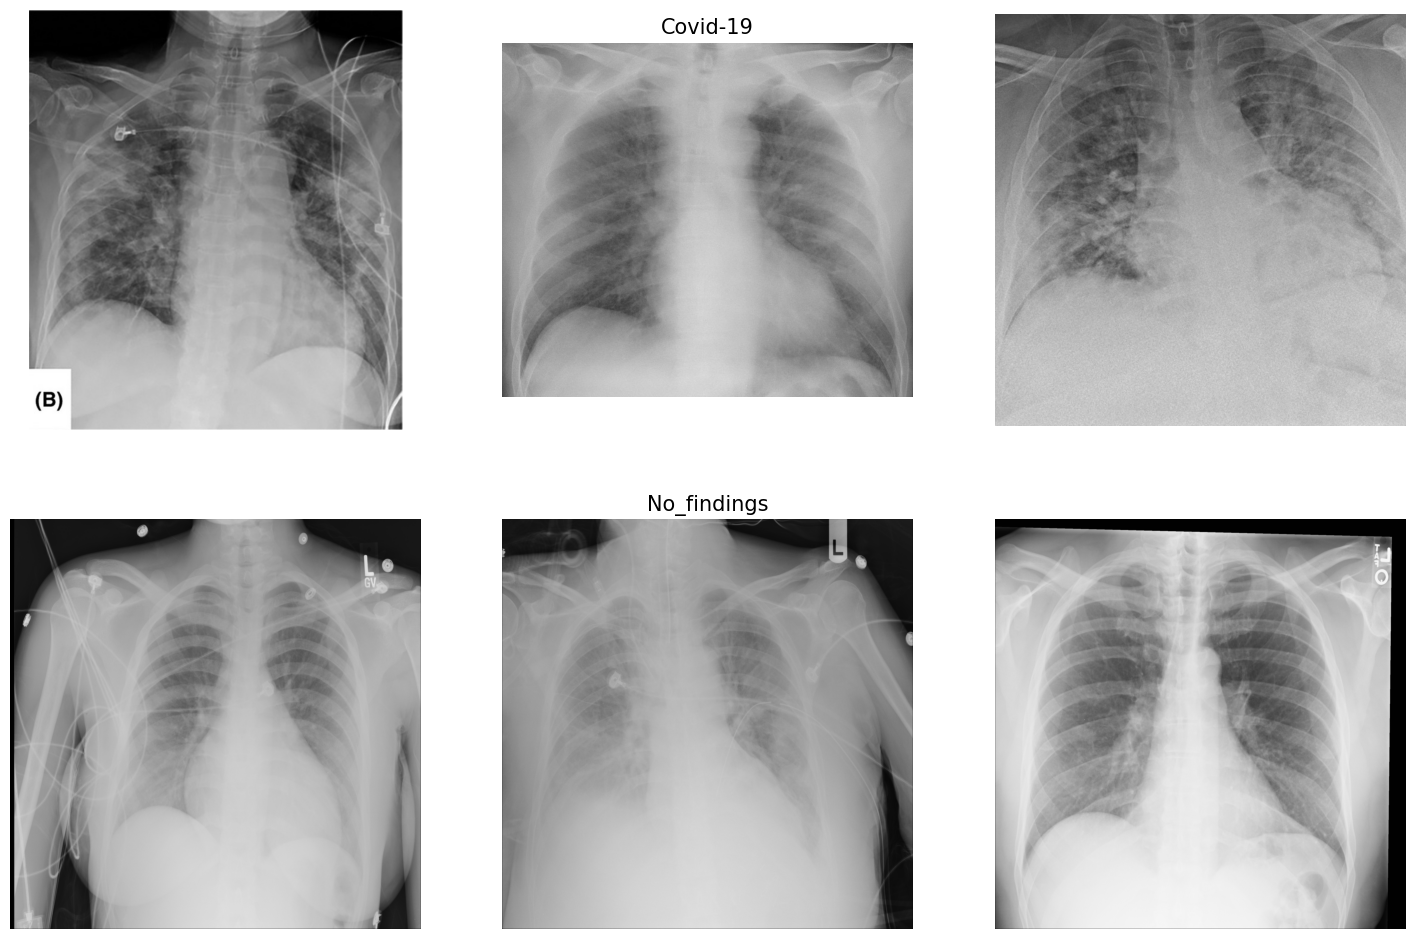

In [92]:
def display_class_sample(df, num_samples_per_class=3, middle_image=1):
    fig, axs = plt.subplots(2, num_samples_per_class, figsize = (6*n_samples, 3*4))

    for ax_row, (label, data) in zip(axs, df.sort_values(['label']).groupby('label')):
        ax_row[middle_image].set_title(label, fontsize = 15)
        for ax, (idx, instance) in zip(ax_row, data.sample(num_samples_per_class).iterrows()):       
            _path = path.join(raw_data_path, instance['label'], instance['image_path'])
            image = cv2.imread(_path)
            ax.imshow(image)
            ax.axis('off')

display_class_sample(test)

# Train Model

## Build DarkCovidNet (modified Darknet model)

In [ ]:
size =3

for_pad = lambda s: s if s > 2 else 3


In [93]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [136]:
def conv_block(num_filters, kernel_size=3, stride=1, padding="same"):
    strides = (stride, stride) # Assuming symmetric stride
    return [
        layers.Conv2D(filters=num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding=padding,
                     use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=1e-2)] # Matching torchvision


In [24]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [137]:
def triple_conv(num_filters_outer, num_filters_inner):
    return [
        *conv_block(num_filters_outer),
        *conv_block(num_filters_inner, kernel_size=1, padding="valid"),
        *conv_block(num_filters_outer)]

In [25]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [114]:
def maxpooling():
    return layers.MaxPool2D((2,2))

In [26]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 2)
)

In [171]:
model = keras.Sequential([
    layers.Input(shape=(256, 256, 3)),
    *conv_block(8),
    maxpooling(),
    *conv_block(16),
    maxpooling(),
    *triple_conv(32, 16),
    maxpooling(),
    *triple_conv(64, 32),
    maxpooling(),
    *triple_conv(128, 64),
    *conv_block(128),
    *conv_block(256),
    layers.Conv2D(filters=2, kernel_size=3, strides=(1,1), padding="valid"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Flatten(),
    layers.Dense(2, activation=None)
]
)

model.build()
  
model.compile(optimizer=tf.keras.optimizers.experimental.AdamW(), #-5 was working well
       loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
       metrics = ['accuracy'], steps_per_execution=1)


In [27]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [140]:

print(model.summary())

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 256, 256, 8)       216       
                                                                 
 batch_normalization_97 (Bat  (None, 256, 256, 8)      32        
 chNormalization)                                                
                                                                 
 leaky_re_lu_97 (LeakyReLU)  (None, 256, 256, 8)       0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 128, 128, 16)      1152      
                                                                 
 batch_normalization_98 (Bat  (None, 128, 128, 16)   

In [28]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

## Fit Model

In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.319721,0.872322,0.200000,00:26
1,0.241996,0.743711,0.256000,00:20
2,0.205166,0.199076,0.920000,00:24


In [ ]:
history = model.fit(train_batches, validation_data=test_batches, epochs=100, workers=8)

Epoch 1/100
16/16 [==============================] - 25s 1s/step - loss: 0.5899 - accuracy: 0.7580 - val_loss: 0.7681 - val_accuracy: 0.2000
Epoch 2/100
16/16 [==============================] - 25s 1s/step - loss: 0.4289 - accuracy: 0.8200 - val_loss: 0.5043 - val_accuracy: 0.8000
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 0.3576 - accuracy: 0.8440 - val_loss: 0.5088 - val_accuracy: 0.8000
Epoch 4/100
16/16 [==============================] - 21s 1s/step - loss: 0.3416 - accuracy: 0.8640 - val_loss: 0.6095 - val_accuracy: 0.8000
Epoch 5/100
16/16 [==============================] - 24s 1s/step - loss: 0.2835 - accuracy: 0.8740 - val_loss: 0.6549 - val_accuracy: 0.8000
Epoch 6/100
16/16 [==============================] - 21s 1s/step - loss: 0.3266 - accuracy: 0.8600 - val_loss: 0.7480 - val_accuracy: 0.8000
Epoch 7/100
16/16 [==============================] - 21s 1s/step - loss: 0.3001 - accuracy: 0.8780 - val_loss: 1.0304 - val_accuracy: 0.8000
Epoch 8/100
 

In [22]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 125


In [25]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [26]:
accuracy(probs,targets)

tensor(0.9760)

In [27]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [28]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

125 122 0.976
[[ 21   3]
 [  0 101]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.88      0.93        24
 No_findings       0.97      1.00      0.99       101

   micro avg       0.98      0.98      0.98       125
   macro avg       0.99      0.94      0.96       125
weighted avg       0.98      0.98      0.98       125



In [29]:
interp = ClassificationInterpretation.from_learner(learn)

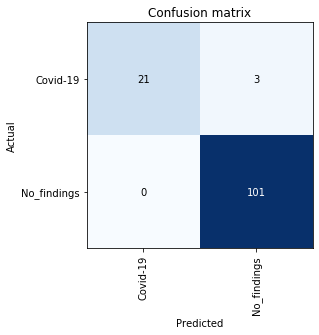

In [30]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);